In [27]:
import pandas as pd
import os
from collections import Counter
import matplotlib.pylab as plt
import gzip
import numpy as np

In [30]:
def num_movies_per_genre(path):
    '''
    path: path to folder containing each year's movies
    '''
    year_genres = []
    most_pop_genres = ['Comedy', 'Drama', 'Western']
    for file in os.listdir(path):
        yearly = []
        year = os.path.splitext(file)[0]
        year = int(year)
        filename = os.path.join('genre', file)
        data = pd.read_csv(filename, header = None)
        for genre in data[2]:
            cleaned = (genre.replace("'", '').replace("[", '').replace("]", '').replace("\\n", ''))
            cleaned = cleaned.split(', ')
            for elem in cleaned:
                if elem != '':
                    if elem.strip() in most_pop_genres:
                        yearly.append(elem.strip())
        yearly = Counter(yearly)
        for key in most_pop_genres:
            if key not in yearly:
                yearly[key] = 0
        yearly = sorted(yearly.items())
        yearly.append(('placeholder', year))
        counts = []
        for tup in yearly:
            counts.append(tup[1])
        year_genres.append(counts)
    df = pd.DataFrame(year_genres)
    df.columns = ['Comedy', 'Drama', 'Western', 'year']
    return df
year_genres = num_movies_per_genre('genre')
year_genres

,Comedy,Drama,Western,year
0,47,50,66,1946
1,65,81,2,1997
2,130,78,116,1941
3,52,62,1,1990
4,128,184,46,1934
5,59,68,92,1948
6,34,49,3,2007
7,10,19,2,1974
8,13,31,15,1973
9,25,52,13,1962


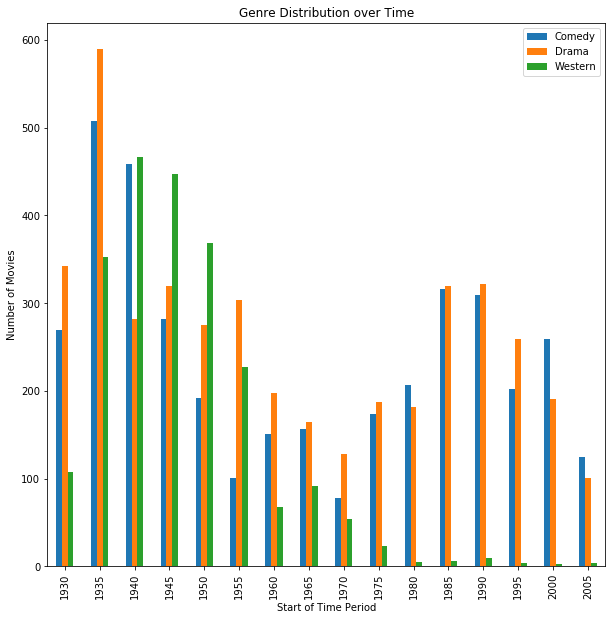

In [95]:
def plot_time_periods(df):
    bins = np.arange(1930, 2015, step = 5)
    df['time'] = pd.cut(df['year'], bins, include_lowest= True)
    grouped_years = df.groupby('time').sum()
    grouped_years = grouped_years.reset_index()
    intervals = list(grouped_years['time'])
    start = [int(round(x.left)) for x in intervals]

    grouped_years['start'] = start
    grouped_years = grouped_years[['Comedy', 'Drama', 'Western', 'start']]
    grouped_years.head()
    grouped_years = grouped_years.set_index('start')
    ax = grouped_years.plot.bar(figsize = (10, 10), title = 'Genre Distribution over Time')
    ax.set_xlabel('Start of Time Period')
    ax.set_ylabel('Number of Movies')
    fig = ax.get_figure()
    fig.show()
    fig.savefig('genre_dist_over_time.png')

plot_time_periods(year_genres)

,year,actor,movie,winner,ethnicity
0,1943,Paul Lukas,Watch on the Rhine,True,"['Ashkenazi', 'Jewish']"
1,1944,Alexander Knox,Wilson,True,[]
2,1945,Ray Milland,The Lost Weekend,True,['Welsh']
3,1946,Gregory Peck,The Yearling,True,"['Irish', 'English', 'German', 'Welsh']"
4,1947,Ronald Colman,A Double Life,True,"['English', 'Scottish']"


In [132]:
golden = pd.read_csv('goldenGlobesDramaWithEthnicity.csv')
golden.head()
race_dict = {'Black': ['AfricanAmerican', 'Ugandan'],
             'Asian': ['Indian', 'Chinese'],
             'Hispanic/Latino': ['Mexican']
            }
def create_race(ethnicities):
    '''
    ethnicities: list of strings
    '''
    ethnicity_string = ''.join(str(elem) for elem in ethnicities)
    for k in race_dict.keys():
        for e in race_dict[k]:
            if e in ethnicity_string:
                return k
    return 'White'

def get_race(df):
    df['race'] = df['ethnicity'].apply(create_race)
    onehot = pd.get_dummies(df['race'])
    df = df.join(onehot)
    df_eth = df[['year','Asian', 'Black', 'Hispanic/Latino', 'White']]
    df_eth['Non_White'] = df_eth['Asian'] + df_eth['Black'] + df_eth['Hispanic/Latino']
    return df_eth
    
golden_eth = get_race(golden)
golden_eth['year'] = golden_eth['year'].str.replace("\[1\]", '')
golden_eth['year'] = pd.to_numeric(golden_eth['year'])
golden_eth.head()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,year,Asian,Black,Hispanic/Latino,White,Non_White
0,1943,0,0,0,1,0
1,1944,0,0,0,1,0
2,1945,0,0,0,1,0
3,1946,0,0,0,1,0
4,1947,0,0,0,1,0


In [133]:
oscars = pd.read_csv('actorsWithEthnicity.csv')
oscars.columns = map(str.lower, oscars.columns)
oscars.head()
oscars_eth = get_race(oscars)
oscars_eth.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,year,Asian,Black,Hispanic/Latino,White,Non_White
0,1934,0,0,0,1,0
1,1934,0,0,0,1,0
2,1934,0,0,0,1,0
3,1935,0,0,0,1,0
4,1935,0,0,0,1,0


In [140]:
def create_time_periods(df):
    bins = np.arange(1930, 2015, step = 5)
    df['time'] = pd.cut(df['year'], bins, include_lowest= True)
    grouped_years = df.groupby('time').sum()
    grouped_years = grouped_years.reset_index()
    intervals = list(grouped_years['time'])
    start = [int(round(x.left)) for x in intervals]

    grouped_years['start'] = start
    grouped_years = grouped_years[['start','Asian', 'Black', 'Hispanic/Latino', 'White', 'Non_White']]
    return grouped_years

oscars_grouped = create_time_periods(oscars_eth)
golden_grouped = create_time_periods(golden_eth)
oscars_grouped
combined = pd.merge(oscars_grouped, golden_grouped, on = 'start', suffixes = ('_osc', '_gold'))

combined.head(10)

,start,Asian_osc,Black_osc,Hispanic/Latino_osc,White_osc,Non_White_osc,Asian_gold,Black_gold,Hispanic/Latino_gold,White_gold,Non_White_gold
0,1930,0,0,0,8,0,0,0,0,0,0
1,1935,0,0,0,25,0,0,0,0,0,0
2,1940,0,0,0,25,0,0,0,0,3,0
3,1945,0,0,0,25,0,0,0,0,8,0
4,1950,0,0,0,25,0,0,0,0,9,0
5,1955,0,0,1,24,1,0,0,0,22,0
6,1960,0,0,1,24,1,0,0,1,30,1
7,1965,0,1,0,24,1,0,1,0,25,1
8,1970,0,0,0,25,0,0,0,0,25,0
9,1975,0,0,0,25,0,0,0,0,25,0


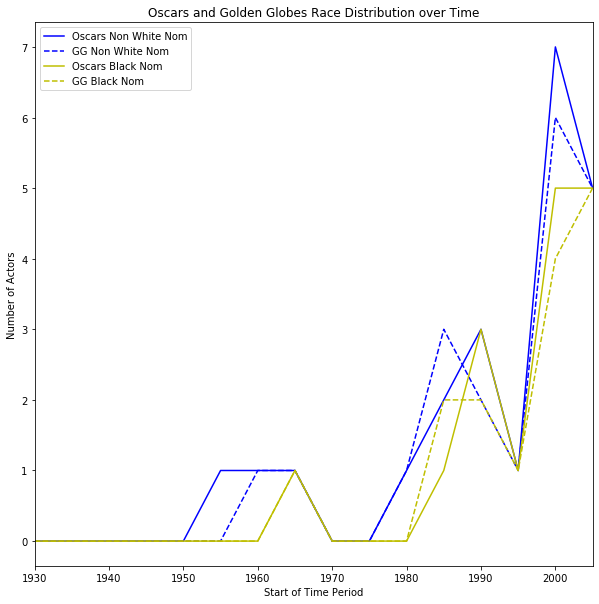

In [154]:
def plot_compare(df, cols):
    styles=['b', 'b--', 'y', 'y--']
    labels = ['Oscars Non White Nom', 'GG Non White Nom', 'Oscars Black Nom', 'GG Black Nom']
    ax = df.plot(x = "start", y = cols, style = styles, figsize = (10, 10), title = 'Oscars and Golden Globes Race Distribution over Time')
    ax.legend(labels = labels)
    ax.set_xlabel('Start of Time Period')
    ax.set_ylabel('Number of Actors')
    fig = ax.get_figure()
    fig.show()
    fig.savefig('race_dist_over_time.png')
plot_compare(combined, ['Non_White_osc', 'Non_White_gold', 'Black_osc', 'Black_gold'])
#plot_compare(combined, ['White_osc', 'White_gold'])